In [1]:
# Allow us to load `open_cp` without installing
import sys, os.path
sys.path.insert(0, os.path.abspath(".."))

# Crime prediction from Hawkes processes

Here we continue to explore the EM algorithm for Hawkes processes, but now concentrating upon:

1. Mohler et al. "Randomized Controlled Field Trials of Predictive Policing". Journal of the American Statistical Association (2015) DOI:10.1080/01621459.2015.1077710

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Simulation of the process in a single cell

In [3]:
import open_cp.sources.sepp as source_sepp

[(-0.1, 0.1), (900, 1000)]

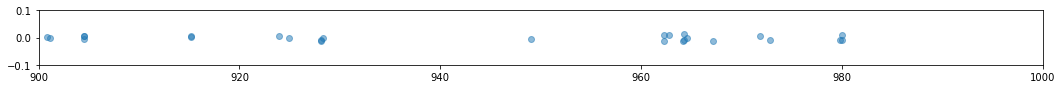

In [4]:
process = source_sepp.SelfExcitingPointProcess(
    background_sampler = source_sepp.HomogeneousPoissonSampler(rate=0.1),
    trigger_sampler = source_sepp.ExponentialDecaySampler(intensity=0.5, exp_rate=10))

events = process.sample(0, 1000)

fig, ax = plt.subplots(figsize=(18,1))
ax.scatter(events, (np.random.random(len(events))-0.5) * 0.03, alpha=.5)
ax.set(xlim=[900, 1000], ylim=[-0.1,0.1])

## Model fitting for cells with varying background rate

We'll create 100 cells with varying background rate, but the same $\omega, \theta$.  We use our library to perform this simulation.

In [5]:
rates = np.random.random(size=100)
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 10)
cells = simulation.sample(0, 1000)

To simulate a steady state, we'll discard the first half of time in each cell.

In [6]:
for i in range(100):
    times = cells[i]
    cells[i] = times[times>=500] - 500

The number of events in each cell varies quite a lot.

In [7]:
min(len(t) for t in cells), max(len(t) for t in cells)

(50, 1020)

In [8]:
import open_cp.seppexp

In [9]:
def optimise(cells, initial_omega=10, iterations=100, time=500):
    omega = initial_omega
    theta = .5
    mu = np.zeros_like(cells) + 0.5

    for _ in range(iterations):
        omega, theta, mu = open_cp.seppexp.maximisation(cells, omega, theta, mu, time)
    return omega, theta, mu

def optimise_corrected(cells, initial_omega=10, iterations=100, time=500):
    omega = initial_omega
    theta = .5
    mu = np.zeros_like(cells) + 0.5

    for _ in range(iterations):
        omega, theta, mu = open_cp.seppexp.maximisation_corrected(cells, omega, theta, mu, time)
    return omega, theta, mu

In [10]:
omega, theta, mu = optimise(cells)
omega, theta

(9.9160029003234627, 0.50624146791930802)

In [11]:
omegac, thetac, muc = optimise_corrected(cells)
omegac, thetac

(9.9082332828340896, 0.50646040691775829)

In [12]:
def plot(rates, mu, ax, title):
    ax.plot([0,1], [0,1], color="red", linewidth=1)
    ax.scatter(rates, mu)
    ax.set(xlim=[0,1], ylim=[0,np.max(mu)*1.05], xlabel="$\\mu$", ylabel="predicted $\\mu$",
         title=title)

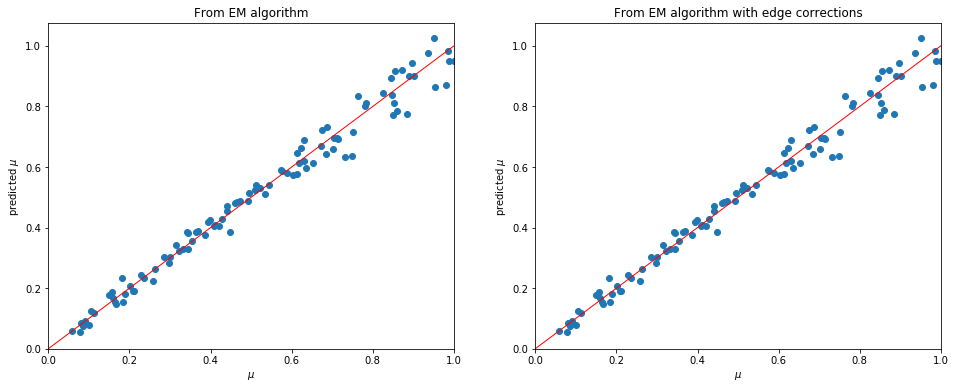

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
plot(rates, mu, ax[0], "From EM algorithm")
plot(rates, muc,ax[1], "From EM algorithm with edge corrections")

Noting that our initial estimate for every $\mu$ is $0.5$, this is good convergence.

## More extreme parameters

However, if we try a rather smaller value of $\omega$, then the optimisation doesn't find the real parameters, tending to systematically over-estimate the background rate $\mu$ and under-estimate the aftershock rate.

In [14]:
rates = np.random.random(size=100)
simulation = source_sepp.GridHawkesProcess(rates, 0.5, .1)
cells = simulation.sample(0, 1000)
for i in range(100):
    times = cells[i]
    cells[i] = times[times>=500] - 500

omega, theta, mu = optimise(cells, .1, 100)
omega, theta

(0.24513930925131727, 0.26171047520116203)

In [15]:
omegac, thetac, muc = optimise_corrected(cells, .1, 100)
omegac, thetac

(0.12986736015742845, 0.38952674753711614)

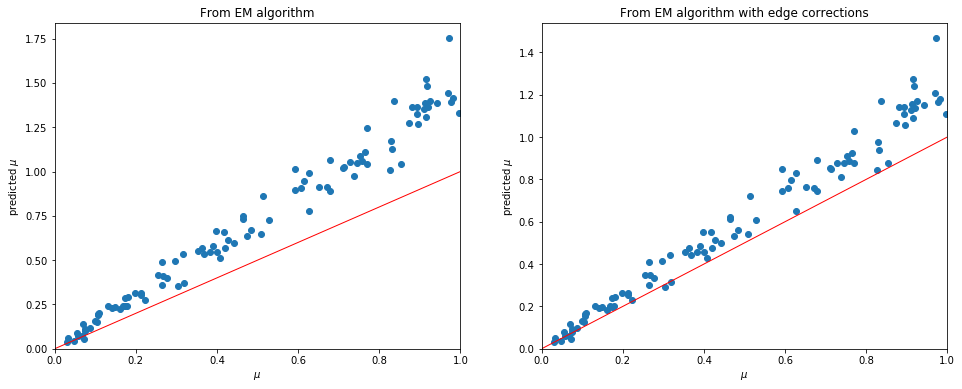

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
plot(rates, mu, ax[0], "From EM algorithm")
plot(rates, muc, ax[1], "From EM algorithm with edge corrections")

## Sampling the whole process, not just a "steady state"

In [17]:
rates = np.random.random(size=100)
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 10)
cells = simulation.sample(0, 1000)
omega, theta, mu = optimise(cells, 1, 100, 1000)
omega, theta

(10.020610766224348, 0.50093343238424803)

In [18]:
omegac, thetac, muc = optimise_corrected(cells, 1, 100, 1000)
omegac, thetac

(10.017284470352703, 0.50100879118301722)

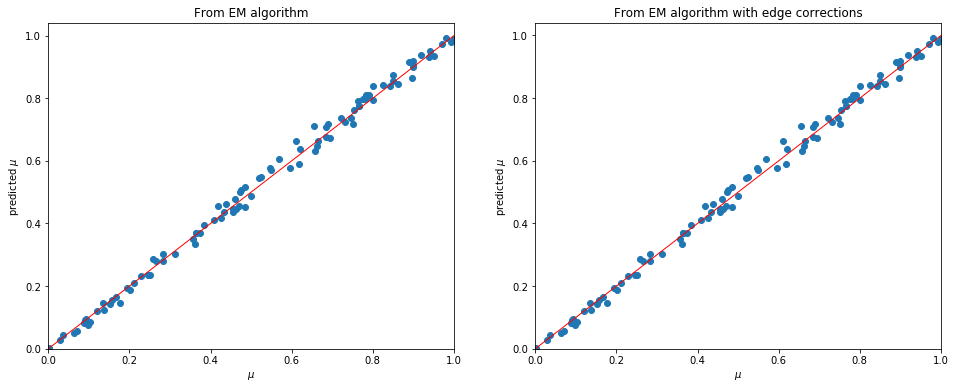

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
plot(rates, mu, ax[0], "From EM algorithm")
plot(rates, muc, ax[1], "From EM algorithm with edge corrections")

## Taking a smaller sample

In [20]:
rates = np.random.random(size=100)
simulation = source_sepp.GridHawkesProcess(rates, 0.5, 10)
cells = simulation.sample(0, 350)

omega, theta, mu = optimise(cells, 1, 100, 350)
omega, theta

(9.9088745874247923, 0.49583401602586197)

In [21]:
omegac, thetac, muc = optimise_corrected(cells, 1, 100, 350)
omegac, thetac

(9.9009132378500482, 0.49600613285918893)

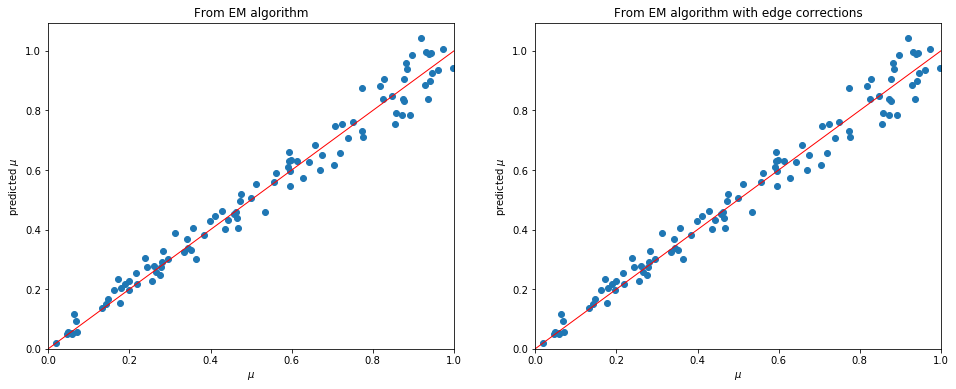

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
plot(rates, mu, ax[0], "From EM algorithm")
plot(rates, muc, ax[1], "From EM algorithm with edge corrections")